# start

In [1]:
PRFX='0317_2'
PRFX_PRP = 'prep0317_2' 
langs = ['2216D01F7B48554E4211021A46816FCF']
trntmstmp=1584412344
valtmstmp=1584405047
import datetime
[datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (trntmstmp, valtmstmp)]

['2020-03-17 02:32:24', '2020-03-17 00:30:47']

# setup

In [2]:
from pathlib import Path
import dask
print('dask.__version__', dask.__version__)
import xgboost
import dask_xgboost
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc
from dask.distributed import Client
import pickle
import lightgbm as lgb

import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_prp=f'{HOME}/output/{PRFX_PRP}'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0


tgts     = ['Retweet','Reply','Like','RTwCmnt',]
cols_tgt = ['retwt',  'reply','like','retwt_cmmnt',]


dask.__version__ 2.12.0


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/dask/array/random.py:27: FutureWarning: dask.array.random.doc_wraps is deprecated and will be removed in a future version
  FutureWarning,


# prepare data

In [3]:
ls $p_prp

cols_cnt.p   dftrn_2216D01F7B48554E4211021A46816FCF_1584412344__prep0317_2.tsv
cols_feat.p  dfval_2216D01F7B48554E4211021A46816FCF_1584405047__prep0317_2.tsv


In [4]:
cols_feat=pickle.load(open(f'{p_prp}/cols_feat.p', 'rb'))
print(cols_feat)

['tm', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed', 'u1_create_tm', 'u2_follower_cnt', 'u2_following_cnt', 'u2_vrfed', 'u2_create_tm', 'u1_fllw_u2', 'len_toks', 'has_media_Photo', 'has_media_Video', 'has_media_GIF', 'num_hshtgs', 'num_links', 'num_domns', 'tmdlta_u2u1', 'tmdlta_twtu1', 'tmdlta_twtu2', 'twttyp_Quote', 'twttyp_Retweet', 'twttyp_TopLevel']


In [6]:
cols_cnt=pickle.load(open(f'{p_prp}/cols_cnt.p', 'rb'))
print(cols_cnt)

['reply_cnt', 'retwt_cnt', 'retwt_cmmnt_cnt', 'like_cnt']


In [7]:
df = dd.concat([dd.read_csv(f'{p_prp}/dftrn_{lang}_{trntmstmp}__{PRFX_PRP}.tsv',sep='\x01') for lang in langs])

In [9]:
df.head()

,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,...,tmdlta_u2u1,tmdlta_twtu1,tmdlta_twtu2,twttyp_Quote,twttyp_Retweet,twttyp_TopLevel,reply,retwt,retwt_cmmnt,like
0,101\t1367\t43877\t20854\t27921\t39578\t1364\t3...,NaN,A4301795BF91376D36101DE9BF1EF530,NaN,NaN,NaN,TopLevel,2216D01F7B48554E4211021A46816FCF,1581152619,26A84E513107F8CCA3FDD38DE56A7AF4,...,-24265405,33240151,57505556,0,0,1,0,0,0,1
1,101\t56898\t137\t169\t168\t182\t168\t177\t168\...,NaN,19B317C489098848A19C90DA4B23CFE2,NaN,NaN,NaN,Retweet,2216D01F7B48554E4211021A46816FCF,1581075564,23AAC02F6EDF248A2E6EB2140BCB9516,...,108239404,239531391,131291987,0,1,0,0,1,0,0
2,101\t1353\t44728\t1353\t23948\t23290\t18384\t4...,NaN,73D91129A17356C8F899343BD5B8801E,NaN,NaN,NaN,TopLevel,2216D01F7B48554E4211021A46816FCF,1581336525,A39F8CD1AF10515208543F6897843B5F,...,-260416547,69013052,329429599,0,0,1,0,0,0,1
3,101\t1357\t23290\t34590\t17896\t47357\t1343\t6...,NaN,F9C9646448986252BCC80EAB7439075E,NaN,NaN,NaN,TopLevel,2216D01F7B48554E4211021A46816FCF,1581080654,4645A47F024F5DB1B0739CD300918D1E,...,161607271,276109615,114502344,0,0,1,0,1,0,1
4,101\t1339\t23948\t75301\t18384\t89291\t49812\t...,30BB2727F7A5665A40430ED55987910F,5BE97362AA81B5A95C7A99606BB96AEB,NaN,NaN,NaN,TopLevel,2216D01F7B48554E4211021A46816FCF,1581057914,C2665B06F7CA141C18240EBB15A738A6,...,-243695622,72450037,316145659,0,0,1,0,0,0,1


In [ ]:
https://stackoverflow.com/questions/40376425/dask-dataframe-equivalent-of-pandas-dataframe-sort-values

In [22]:
lendf = df.shape[0].compute()
valsz = int(lendf*0.15)
trnsz = lendf-valsz
trnsz, valsz

(12706, 2242)

In [25]:
dftr=df.nsmallest(trnsz,'tm')

In [26]:
dfvl=df.nlargest(valsz,'tm')

In [30]:
dask.compute(dftr.tm.max(), dfvl.tm.min())

(1581435363, 1581435462)

In [32]:
def prepcnts(dftrn,dfval):
    for coltgt in cols_tgt:
        dfpos=dftrn[dftrn[coltgt]==1]
        dfcnt=dfpos.groupby(['u1id', 'u2id']).size().reset_index()
        dfcnt.columns=['u1id','u2id',f'{coltgt}_cnt']
        dfval = dd.merge(dfval,dfcnt,how='left',left_on=['u1id','u2id'],right_on=['u1id', 'u2id'])
        dfval[f'{coltgt}_cnt'] = dfval[f'{coltgt}_cnt'].fillna(0)
    cols_cnt = [f'{coltgt}_cnt' for coltgt in cols_tgt]
    return dfval, cols_cnt

In [33]:
dfvl,cols_cnt=prepcnts(dftr,dfvl)

In [34]:
dfvl.head()

,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,...,twttyp_Retweet,twttyp_TopLevel,reply,retwt,retwt_cmmnt,like,retwt_cnt,reply_cnt,like_cnt,retwt_cmmnt_cnt
0,101\t1352\t47025\t104612\t98071\t1334\t24458\t...,NaN,FDEC26B12A3FA50CC5DA9C39DDAB4AE8,NaN,NaN,NaN,TopLevel,2216D01F7B48554E4211021A46816FCF,1581551854,D0119682C508B9328AEB1EF4E3C4A83B,...,0,1,0,0,0,0,0.0,0.0,0.0,0.0
1,101\t1355\t24164\t23290\t78762\t1343\t59009\t1...,NaN,334C048F85C3977C548AD7320D54E60B,NaN,NaN,NaN,TopLevel,2216D01F7B48554E4211021A46816FCF,1581550978,69C7E327EE2919E98102BD3B8DB9C07F,...,0,1,0,0,0,0,0.0,0.0,0.0,0.0
2,101\t1334\t18384\t75301\t54885\t38847\t69718\t...,NaN,5FFFC779EEDA8636A7D1F91DA723A9EB,NaN,637F4DA3BD816892D454C677941DD3F5,FB9F3CB6CE66297265636B371B494BB6,TopLevel,2216D01F7B48554E4211021A46816FCF,1581548595,0DBD3A2D01DEA0DD1A755B7C6F9D3DD2,...,0,1,0,0,0,0,0.0,0.0,0.0,0.0
3,101\t1359\t24458\t111400\t18384\t15080\t1364\t...,NaN,01F5D0EA82A6EFE51E1685E9A6B0FFD9,Photo,NaN,NaN,TopLevel,2216D01F7B48554E4211021A46816FCF,1581547942,BEE5F18BF0403F625194062E523A9472,...,0,1,0,0,0,0,0.0,0.0,0.0,0.0
4,101\t78953\t89291\t111395\t18384\t1367\t18384\...,NaN,6FFC5BCB8B8D71B0811780074EA9DC7F,NaN,NaN,NaN,TopLevel,2216D01F7B48554E4211021A46816FCF,1581547846,BEE5F18BF0403F625194062E523A9472,...,0,1,0,0,0,1,0.0,0.0,0.0,0.0


In [43]:
X, ys = (df[cols].to_dask_array(lengths=True) for cols in (cols_feat,cols_tgt))

Xtrn, Xval, ystrn, ysval = train_test_split(X, ys, test_size=0.15, random_state=SEED)

# train

In [44]:
client = Client()

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [45]:
params = {'objective': 'binary:logistic'}

In [48]:
tgt2bst={}
tgt2col2fscr={}
for i,tgt in enumerate(tgts):
    bst = dask_xgboost.train(client, params,
                             Xtrn, ystrn[:,i],
                             num_boost_round=20)
    tgt2bst[tgt]=bst
    print(dtnow(), tgt)
    
    fi2col=dict(zip(bst.feature_names, cols_feat))
    col2fi=dict(zip(cols_feat, bst.feature_names))
    fi2fscr=bst.get_fscore()
    col2fscr={col:fi2fscr.get(fi,0) for col,fi in col2fi.items()}
    tgt2col2fscr[tgt]=col2fscr

pickle.dump(tgt2bst, open(f"{p_out}/tgt2bst.p", "wb"))

2020-03-18 01:38:03 Retweet
2020-03-18 01:38:03 Reply
2020-03-18 01:38:04 Like
2020-03-18 01:38:05 RTwCmnt


In [49]:
tgt2bst=pickle.load(open(f"{p_out}/tgt2bst.p", "rb"))

In [50]:
def show_feat_importance(bst):
    ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title('Estimated feature importance')
    plt.show()

for i,tgt in enumerate(tgts):
    print(tgt)
#     show_feat_importance(tgt2bst[tgt])
    col2fscr=tgt2col2fscr[tgt]
    display(pd.DataFrame(col2fscr.items()).sort_values(1, ascending=False))

Retweet


,0,1
0,tm,59
10,len_toks,57
24,retwt_cnt,36
26,like_cnt,32
1,u1_fllwer_cnt,26
2,u1_fllwing_cnt,25
8,u2_create_tm,24
5,u2_follower_cnt,24
6,u2_following_cnt,19
18,tmdlta_twtu1,14


Reply


,0,1
0,tm,61
10,len_toks,50
23,reply_cnt,31
6,u2_following_cnt,27
26,like_cnt,27
1,u1_fllwer_cnt,25
5,u2_follower_cnt,24
17,tmdlta_u2u1,23
2,u1_fllwing_cnt,21
8,u2_create_tm,20


Like


,0,1
0,tm,57
1,u1_fllwer_cnt,45
10,len_toks,44
6,u2_following_cnt,43
26,like_cnt,36
5,u2_follower_cnt,33
8,u2_create_tm,30
17,tmdlta_u2u1,25
23,reply_cnt,24
4,u1_create_tm,21


RTwCmnt


,0,1
10,len_toks,37
25,retwt_cmmnt_cnt,20
0,tm,16
26,like_cnt,14
18,tmdlta_twtu1,12
5,u2_follower_cnt,8
1,u1_fllwer_cnt,7
6,u2_following_cnt,6
8,u2_create_tm,5
4,u1_create_tm,4


# validate

In [51]:
tgt2yval={}
tgt2prdval={}
for i,tgt in enumerate(tgts):
    print(dtnow(), tgt)
    prdval = dask_xgboost.predict(client, tgt2bst[tgt], Xval).persist()
    yval, prdval = dask.compute(ysval[:,i], prdval)
    tgt2yval[tgt]=yval
    tgt2prdval[tgt]=prdval

2020-03-18 01:40:46 Retweet
2020-03-18 01:40:47 Reply
2020-03-18 01:40:47 Like
2020-03-18 01:40:47 RTwCmnt


In [52]:
def show_roc(prd,y):
    fpr, tpr, _ = roc_curve(y,prd)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(fpr, tpr, lw=3,
            label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set(
        xlim=(0, 1),
        ylim=(0, 1),
        title="ROC Curve",
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
    )
    ax.legend();
    plt.show()

Retweet
auc: 0.9682604092403213
rce: 90.30719836077269


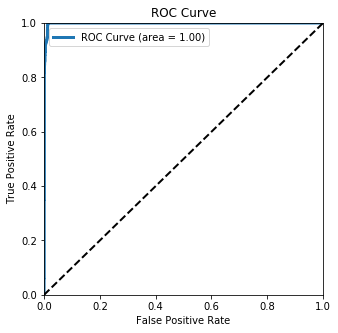

Reply
auc: 0.9362277096505576
rce: 85.22681079436525


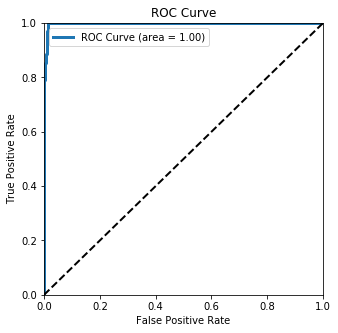

Like
auc: 0.9902713824524193
rce: 90.34828772236845


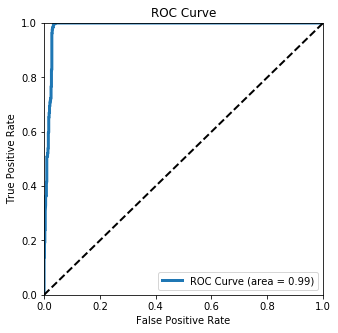

RTwCmnt
auc: 0.930701788090452
rce: 81.01493981453628


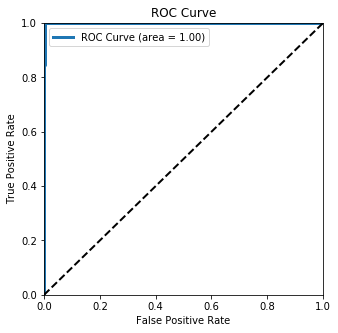

In [53]:
tgt2auc={}
tgt2rce={}
for i,tgt in enumerate(tgts):
    print(tgt)
    yval = tgt2yval[tgt]
    prdval = tgt2prdval[tgt]
    scr_auc=compute_prauc(prdval, yval)
    scr_rce=compute_rce(prdval, yval)
    tgt2auc[tgt]=scr_auc
    tgt2rce[tgt]=scr_rce
    print('auc:',scr_auc)
    print('rce:', scr_rce)
    show_roc(prdval, yval)

In [54]:
lst=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    lst+=[(f'PRAUC {tgt}',tgt2auc[tgt]),
          (f'RCE {tgt}',tgt2rce[tgt])]

In [55]:
pd.DataFrame(lst).T

,0,1,2,3,4,5,6,7
0,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
1,0.96826,90.3072,0.936228,85.2268,0.990271,90.3483,0.930702,81.0149


# infer

In [63]:
ls {p_in} | grep {valtmstmp}

val_12D8CEB94F89D11D7EB95EAE9689B009_1584405047.tsv
val_1584405047_1e3.tsv
val_1584405047.tsv*
val_2216D01F7B48554E4211021A46816FCF_1584405047.tsv
val_2E18F6F53E3CF073911AF0A93BBE5373_1584405047.tsv
val_4690215948DBF6872B8ED1C2BC87B17E_1584405047.tsv
val_515E873C86EE1577E75FA2387B7FA59E_1584405047.tsv
val_60A3DB168094D41241E45E0DE3539BC0_1584405047.tsv
val_97F81BD92A1ACA3F1F43C154E689350F_1584405047.tsv
val_B2235C8B73239FDC5780DD132419833A_1584405047.tsv
val_BF477808A37E3E4E9C5D9F1839E8519E_1584405047.tsv
val_D18801336202297E6484F634CAC6592E_1584405047.tsv
val_F73266A79468BB89C4325FDEDB0B533C_1584405047.tsv


In [62]:
ls {p_prp} | grep {valtmstmp}

dfval_2216D01F7B48554E4211021A46816FCF_1584405047__prep0317_1.tsv


In [61]:
dftst=dd.read_csv(
    f'{p_prp}/val_{valtmstmp}.tsv',
    sep='\x01',
    header=None,
    names=cols_val,
    encoding='utf8')

NameError: name 'cols_val' is not defined

In [31]:
%%time
Xtst, cols_feat = makeX(dftst)

CPU times: user 20.7 s, sys: 1.99 s, total: 22.6 s
Wall time: 1min 18s


In [32]:
%%time
tgt2prdtst={}
for i,tgt in enumerate(tgts):
    prdtst = dask_xgboost.predict(client, tgt2bst[tgt], Xtst)
    prdtst = prdtst
    tgt2prdtst[tgt]=prdtst 

CPU times: user 7.29 ms, sys: 544 µs, total: 7.83 ms
Wall time: 5.45 ms


In [33]:
dfsub_ids = dftst[['tweet_id','engaging_user_id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [34]:
%%time
for tgt, dfsub in tgt2dfsub.items():
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False,single_file=True)

2020-03-16 13:15:32 Retweet
2020-03-16 13:17:28 Reply
2020-03-16 13:19:24 Like
2020-03-16 13:21:20 RTwCmnt
CPU times: user 1min 10s, sys: 9.83 s, total: 1min 20s
Wall time: 7min 43s


In [35]:
# %%time
# for tgt in tgts:
#     print(dtnow(), tgt)
#     dfsub = pd.concat(pd.read_csv(o, header=None) for o in sorted(glob.glob(f'{p_out}/{tgt}__{PRFX}_*.csv')))
#     dfsub.to_csv(f'{p_out}/{tgt}__{PRFX}.csv', 
#                           index=False, 
#                           header=False)

In [36]:
!head -n 2 {p_prp}/val_{valtmstmp}.tsv

101	47185	10157	100986	10343	55422	119	14120	131	120	120	188	119	11170	120	162	10162	10575	10237	11281	10123	11305	11537	10350	10115	1027647B4E9DAF4C1D8973397DC2A04F3E3PhotoTopLevelD3164C7FBCF2565DDF915B1B3AEFB1DC15817031268A9AB92B775C62C4AB60DF6773A01571139411216false14482921860000006C3074607050F1339DDCB890BB27448600false1520948869true
101	6006	5086	1939	7418	3601	6406	1913	3800	21252	18767	2369	5322	8255	3671	14813	20058	4335	1912	22480	111814	18872	91872	108247	12236	5078	1923	11312	16838	15802	18825	60847	1881	1881	1881	4476	3740	65236	10898	103305	1881	1881	1881	1881	1881	1881	3102	77509	4726	1939	2195	2149	11592	15802	50508	52310	1881	1881	1881	1881	1881	1881	1881	14120	131	120	120	188	119	11170	120	153	10477	13034	12674	58123	10929	10410	102CCBFBA5AFE7EFC03102EA8D0F86C4208PhotoTopLevel22C448FF81263D4BAF2A176145EE9EAD1581736431187AC59639DA9A6F32F7CD118EDD58F74764391478false125444772200000776B07587ECA9717BFC301F2D6E102659false1478011810false


In [37]:
for tgt in tgts:
    !head -n 2 {p_out}/{tgt}__{valtmstmp}__{PRFX}.csv

7647B4E9DAF4C1D8973397DC2A04F3E3,0000006C3074607050F1339DDCB890BB,0.08658835
CCBFBA5AFE7EFC03102EA8D0F86C4208,00000776B07587ECA9717BFC301F2D6E,0.10320493
7647B4E9DAF4C1D8973397DC2A04F3E3,0000006C3074607050F1339DDCB890BB,0.07894471
CCBFBA5AFE7EFC03102EA8D0F86C4208,00000776B07587ECA9717BFC301F2D6E,0.020714642
7647B4E9DAF4C1D8973397DC2A04F3E3,0000006C3074607050F1339DDCB890BB,0.44839406
CCBFBA5AFE7EFC03102EA8D0F86C4208,00000776B07587ECA9717BFC301F2D6E,0.37307036
7647B4E9DAF4C1D8973397DC2A04F3E3,0000006C3074607050F1339DDCB890BB,0.014331817
CCBFBA5AFE7EFC03102EA8D0F86C4208,00000776B07587ECA9717BFC301F2D6E,0.0054969722


# old

In [29]:
tgts=['Retweet','Reply','Like','RTwCmnt',]
cols_tgt=['retweet', 'reply', 'like', 'retweet_with_comment']

In [32]:
dftrn = pd.read_csv(f'{p_prp}/dftrn_prep_{trntmstmp}__{PRFX_PRP}.csv', nrows=5)
dfval = pd.read_csv(f'{p_prp}/dfval_prep_{valtmstmp}__{PRFX_PRP}.csv', nrows=5)

In [33]:
datatrn=lgb.Dataset(f'{p_prp}/dftrn_prep_{trntmstmp}__{PRFX_PRP}.csv')
dataval=lgb.Dataset(f'{p_prp}/dfval_prep_{valtmstmp}__{PRFX_PRP}.csv')

In [34]:
dftrn.head()

,timestamp,engaged_follower_count,engaged_following_count,engaged_is_verified,engaged_account_creation_time,engaging_follower_count,engaging_following_count,engaging_is_verified,engaging_account_creation_time,engagee_follows_engager,...,tmdelta_engng_enged,tmdelta_enged_tweet,tmdelta_engng_tweet,tweet_type_TopLevel,tweet_type_Retweet,tweet_type_Quote,retweet,reply,like,retweet_with_comment
0,1581258144,3517,590,False,1391702737,27428,600,False,1520948869,False,...,129246132,-189555407,-60309275,1,0,0,0,0,0,0
1,1581018910,39786,32978,False,1322740272,17,77,False,1569692352,True,...,246952080,-258278638,-11326558,1,0,0,0,0,0,0
2,1581244866,141726,3232,False,1343181073,2,29,False,1568107028,False,...,224925955,-238063793,-13137838,1,0,0,0,0,1,0
3,1581250124,3044,99,False,1350921963,3,30,False,1568107028,False,...,217185065,-230328161,-13143096,1,0,0,0,0,0,0
4,1580958805,141370,3235,False,1343181073,3,30,False,1568107028,False,...,224925955,-237777732,-12851777,1,0,0,0,0,0,0


In [38]:
cols_feat, cols_tgt=dftrn.columns[:-4], dftrn.columns[-4:]

In [46]:
ds=lgb.Dataset(data=f'{p_prp}/dftrn_prep_{trntmstmp}__{PRFX_PRP}.csv',
                    label=cols_tgt, feature_name=cols_feat)

In [47]:
dsval=lgb.Dataset(data=f'{p_prp}/dfval_prep_{valtmstmp}__{PRFX_PRP}.csv', feature_name=cols_feat)

In [48]:
param = {'num_leaves': 31, 'objective': 'binary', 'metric':['auc', 'binary_logloss']}

In [49]:
param

{'num_leaves': 31, 'objective': 'binary', 'metric': ['auc', 'binary_logloss']}

In [50]:
bst = lgb.train(param, ds, num_boost_round=10, valid_sets=[dsval])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()